# Homework 2 Solution - Berkeley STAT 157

Handout 1/29/2019, due 2/5/2019 by 4pm in Git by committing to your repository.

In [1]:
from mxnet import nd, autograd, gluon
import numpy as np
import bisect
from matplotlib import pyplot as plt
%matplotlib inline

# 1. Multinomial Sampling

Implement a sampler from a discrete distribution from scratch, mimicking the function `mxnet.ndarray.random.multinomial`. Its arguments should be a vector of probabilities $p$. You can assume that the probabilities are normalized, i.e. tha they sum up to $1$. Make the call signature as follows:

```
samples = sampler(probs, shape) 

probs   : An ndarray vector of size n of nonnegative numbers summing up to 1
shape   : A list of dimensions for the output
samples : Samples from probs with shape matching shape
```

Hints:

1. Use `mxnet.ndarray.random.uniform` to get a sample from $U[0,1]$.
1. You can simplify things for `probs` by computing the cumulative sum over `probs`.

In [2]:
def sampler(probs, shape):
    ## Add your codes here
    size = np.prod(shape)
    probsCS = np.cumsum(probs)
    samp = nd.array([np.argmax(np.random.uniform(0,1) < 
                               np.array(probsCS)) for i in range(size)])
    return samp.reshape(shape) 

# a simple test
sampler(nd.array([0.2, 0.3, 0.5]), (2,3))


[[2. 2. 2.]
 [1. 0. 2.]]
<NDArray 2x3 @cpu(0)>

# 2. Central Limit Theorem

Let's explore the Central Limit Theorem when applied to text processing. 

* Download [https://www.gutenberg.org/ebooks/84](https://www.gutenberg.org/files/84/84-0.txt) from Project Gutenberg 
* Remove punctuation, uppercase / lowercase, and split the text up into individual tokens (words).
* For the words `a`, `and`, `the`, `i`, `is` compute their respective counts as the book progresses, i.e. 
    $$n_\mathrm{the}[i] = \sum_{j = 1}^i \{w_j = \mathrm{the}\}$$
* Plot the proportions $n_\mathrm{word}[i] / i$ over the document in one plot.
* Find an envelope of the shape $O(1/\sqrt{i})$ for each of these five words. (Hint, check the last page of the [sampling notebook](http://courses.d2l.ai/berkeley-stat-157/slides/1_24/sampling.pdf))
* Why can we **not** apply the Central Limit Theorem directly? 
* How would we have to change the text for it to apply? 
* Why does it still work quite well?

﻿
Project Gutenberg's Frankenstein, by Mary Wollstonecraft (Godwin) Shelley

This eBook is for the u


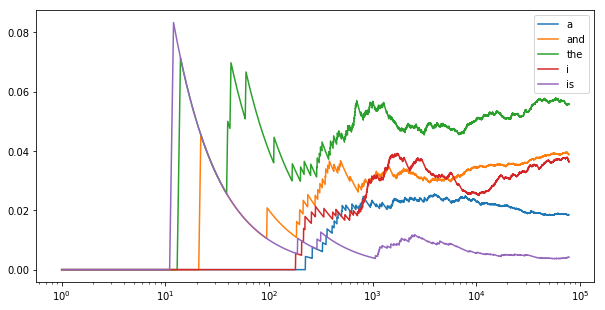

In [3]:
filename = gluon.utils.download('https://www.gutenberg.org/files/84/84-0.txt')
with open(filename) as f:
    book = f.read()
print(book[0:100])

## 2. Remove punctuation, uppercase / lowercase, and split the text up into individual tokens (words).
import re
book = book.lower()
book = re.sub(r'\\n|\d+|_', ' ', book)
book = re.findall(r'\w+',book)

## 3. For the words a, and, the, i, is compute their respective counts as the book progresses
words = ["a", "and", "the", "i", "is"]
counter = np.zeros((len(words), len(book)))
for j in range(len(book)):
    for i in range(len(words)):
        counter[i][j] = 1.0 * (book[j] == words[i])
for i in range(len(words)):
    counter[i] = np.cumsum(counter[i])
x = np.arange(1, len(book)+1)
proportion = counter/x


## 4. Plot the proportions over the document in one plot.
plt.figure(figsize=(10, 5))
for i in range(len(words)):
    plt.semilogx(x, proportion[i], label=words[i])
plt.legend()
plt.show()

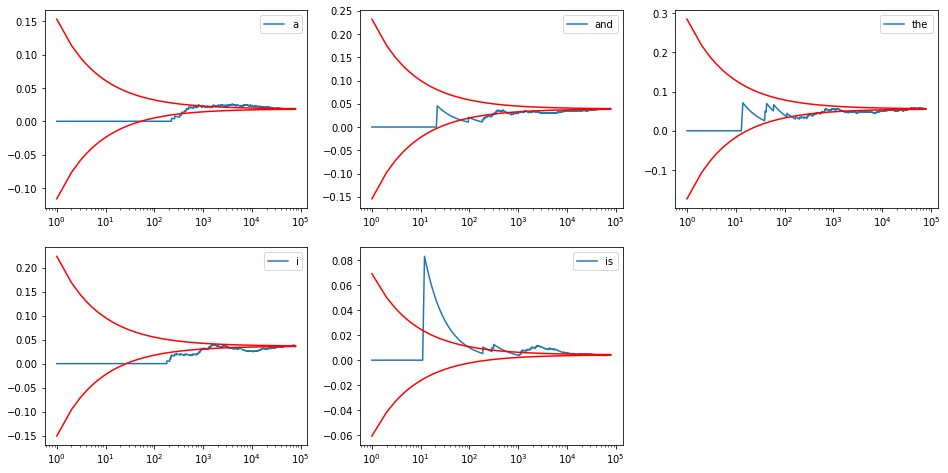

In [4]:
## 5. Find an envelope of the shape  𝑂(1/√i)  for each of these five words. 
fig = plt.figure(figsize=(16, 8))
for i in range(len(words)):
    p = proportion[i][-1]
    up = ((p*(1-p))**0.5) * x**(-0.5) + p
    low = -((p*(1-p))**0.5) * x**(-0.5) + p

    fig.add_subplot(2, 3, i+1)
    plt.semilogx(x, proportion[i], label=words[i])
    plt.semilogx(x, up, 'r')
    plt.semilogx(x, low, 'r')
    plt.legend()


**6. Why can we not apply the Central Limit Theorem directly?**

Answer: Due to the fact that the words do not independently appear in the text, the samples of proportion of each word are not independent. For example if the word "the" appears at the 5th index, it is highly unlikely that the word "the" will appear in the 6th index. To be able to apply the central limit theorem directly, each proportion that we plot should be independent of all the previous proportions.

**7. How would we have to change the text for it to apply?**

Answer: If we want to be able to apply the central limit theorem directly, we should sample words randomly from the text and calculate the proportion the target word shows up and calculate all the proportions for Doing this will ensure that every proportion that we calculate is independent of the previously calculated proportions.

**8.Why does it still work quite well?**

Answer: However the central limit theorem still works well because the dependencies are probably the most significant for proportions close together and as the sample proportion indices get further and further apart, they are pretty much independent. For example seeing the word "a" appear as the first word of the book is pretty much independent to seeing the word "a" appear as one of the last words of the book. 


## 3. Denominator-layout notation

We used the numerator-layout notation for matrix calculus in class, now let's examine the denominator-layout notation.

Given $x, y\in\mathbb R$, $\mathbf x\in\mathbb R^n$ and $\mathbf y \in \mathbb R^m$, we have

$$
\frac{\partial y}{\partial \mathbf{x}}=\begin{bmatrix}
\frac{\partial y}{\partial x_1}\\
\frac{\partial y}{\partial x_2}\\
\vdots\\
\frac{\partial y}{\partial x_n}
\end{bmatrix},\quad 
\frac{\partial \mathbf y}{\partial {x}}=\begin{bmatrix}
\frac{\partial y_1}{\partial x}, 
\frac{\partial y_2}{\partial x}, 
\ldots,
\frac{\partial y_m}{\partial x}
\end{bmatrix}
$$

and 

$$
\frac{\partial \mathbf y}{\partial \mathbf{x}}
=\begin{bmatrix}
\frac{\partial \mathbf y}{\partial {x_1}}\\
\frac{\partial \mathbf y}{\partial {x_2}}\\
\vdots\\
\frac{\partial \mathbf y}{\partial {x_3}}\\
\end{bmatrix}
=\begin{bmatrix}
\frac{\partial y_1}{\partial x_1}, 
\frac{\partial y_2}{\partial x_1},
\ldots,
\frac{\partial y_m}{\partial x_1}
\\ 
\frac{\partial y_1}{\partial x_2},
\frac{\partial y_2}{\partial x_2},
\ldots,
\frac{\partial y_m}{\partial x_2}\\ 
\vdots\\
\frac{\partial y_1}{\partial x_n},
\frac{\partial y_2}{\partial x_n},
\ldots,
\frac{\partial y_m}{\partial x_n}
\end{bmatrix}
$$

Questions: 

1. Assume $\mathbf  y = f(\mathbf u)$ and $\mathbf u = g(\mathbf x)$, write down the chain rule for $\frac {\partial\mathbf  y}{\partial\mathbf x}$
2. Given $\mathbf X \in \mathbb R^{m\times n},\ \mathbf w \in \mathbb R^n, \ \mathbf y \in \mathbb R^m$, assume $z = \| \mathbf X \mathbf w - \mathbf y\|^2$, compute $\frac{\partial z}{\partial\mathbf w}$.

**Answer:**  

1. Using denominator-layout: $\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \frac{\partial \mathbf{u}}{\partial \mathbf{x}}\frac{\partial \mathbf{y}}{\partial \mathbf{u}}$

2. Let $\mathbf{u} =  \mathbf X \mathbf w - \mathbf y\ $, then $\mathbf u \in \mathbb{R}^{m \times 1} \text{ and } z = \|\mathbf{u}\|^2$ $\implies \frac{\partial z}{\partial\mathbf w} = \frac{\partial \mathbf u}{\partial\mathbf w}\frac{\partial z}{\partial\mathbf u}$. Check the dimension (using denominator-layout): $\frac{\partial z}{\partial\mathbf w}$ should have $n \times 1$ dimension. This is satisfied since $\frac{\partial \mathbf u}{\partial\mathbf w}$ has dimension $n \times m$ and $\frac{\partial z}{\partial\mathbf u}$ has dimension $m \times 1$.

$$
\begin{align*}
\frac{\partial \mathbf u}{\partial\mathbf w} &= X^\top \\
\frac{\partial z}{\partial\mathbf u} &= 2u \\
\implies \frac{\partial z}{\partial\mathbf w} &= 2X^\top u \\
&= 2X^\top X w - 2 X^\top y
\end{align*}$$

## 4. Numerical Precision

Given scalars `x` and `y`, implement the following `log_exp` function such that it returns 
$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$.

In [5]:
def log_exp(x, y):
    ## add your solution here
    return -nd.log(nd.exp(x) / (nd.exp(x) + nd.exp(y)))

Test your codes with normal inputs:

In [6]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z


[1.3132617]
<NDArray 1 @cpu(0)>

Now implement a function to compute $\partial z/\partial x$ and $\partial z/\partial y$ with `autograd`

In [7]:
def grad(forward_func, x, y):
    x.attach_grad()
    y.attach_grad()
    with autograd.record():
        z = forward_func(x, y)
    z.backward()
    print('x.grad =', x.grad)
    print('y.grad =', y.grad)

Test your codes, it should print the results nicely. 

In [8]:
grad(log_exp, x, y)

x.grad = 
[-0.7310586]
<NDArray 1 @cpu(0)>
y.grad = 
[0.7310586]
<NDArray 1 @cpu(0)>


But now let's try some "hard" inputs

In [9]:
x, y = nd.array([50]), nd.array([100])
grad(log_exp, x, y)

x.grad = 
[nan]
<NDArray 1 @cpu(0)>
y.grad = 
[nan]
<NDArray 1 @cpu(0)>


Does your code return correct results? If not, try to understand the reason. (Hint, evaluate `exp(100)`). Now develop a new function `stable_log_exp` that is identical to `log_exp` in math, but returns a more numerical stable result.

In [10]:
def stable_log_exp(x, y):
    ## Add your codes here
    z = nd.maximum(x, y)
    return -x + z + nd.log(nd.exp(x - z) + nd.exp(y - z))
grad(stable_log_exp, x, y)

x.grad = 
[-1.]
<NDArray 1 @cpu(0)>
y.grad = 
[1.]
<NDArray 1 @cpu(0)>
